# Testing Navier-Stokes with a body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a cylinder

In [6]:
nx = 202; ny = 102;
Re = 200
U = 1.0
U∞ = (U,0.0)
Lx = 2.0;
Δx = Lx/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
q = Edges(Primal,w₀);

Set up points on the cylinder

In [3]:
n = 100;
a = 0.5; b = 0.1;
body = Bodies.Ellipse(a,b,n);

xc = (1.0,1.0)
α = π/4
T = RigidTransform(xc,α)
T(body)

ds = Bodies.ds(body)
X = VectorData(body.x,body.y)
f = VectorData(X);

In [7]:
regop = Regularize(X,Δx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(regop,f,q);

In [8]:
B₂(w::Nodes) = -(Emat*(Curl()*(sys.L\w)))

B₂ (generic function with 1 method)

In [9]:
B₁ᵀ(f::VectorData) = Curl()*(Hmat*f)

B₁ᵀ (generic function with 1 method)

In [10]:
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞)

Navier-Stokes system on a grid of size 202 x 102

In [11]:
function r₂(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY}
    f = VectorData(X)
    fill!(f.u,-U∞[1])
    fill!(f.v,-U∞[2])
    return f
end

r₂ (generic function with 1 method)

In [12]:
ifherk = IFHERK(w₀,f,sys.Δt,
                (t,w) -> Systems.plan_intfact(t,w,sys),
                (B₁ᵀ, B₂),
                ((w,t) -> Systems.r₁(w,t,sys),
                 (w,t) -> r₂(w,t)),rk=TimeMarching.RK31,store=true)

Order-3 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{100}
   Time step size 0.01


In [13]:
t = 0.0
w₀ .= 0.0
w = deepcopy(w₀)
tf = 2
T = 0:Δt:tf;

In [12]:
using BenchmarkTools

In [13]:
@benchmark ifherk.r₁($w,$t)

BenchmarkTools.Trial: 
  memory estimate:  961.84 KiB
  allocs estimate:  18
  --------------
  minimum time:     3.575 ms (0.00% GC)
  median time:      4.163 ms (0.00% GC)
  mean time:        4.348 ms (3.31% GC)
  maximum time:     9.010 ms (39.41% GC)
  --------------
  samples:          1147
  evals/sample:     1

In [14]:
@benchmark ifherk.H[1]*ifherk.r₁($w,$t)

BenchmarkTools.Trial: 
  memory estimate:  1.10 MiB
  allocs estimate:  21
  --------------
  minimum time:     6.970 ms (0.00% GC)
  median time:      7.808 ms (0.00% GC)
  mean time:        8.031 ms (2.10% GC)
  maximum time:     12.980 ms (28.43% GC)
  --------------
  samples:          622
  evals/sample:     1

In [15]:
@benchmark ifherk.S[1]\($w,$f)

BenchmarkTools.Trial: 
  memory estimate:  1.88 MiB
  allocs estimate:  10718
  --------------
  minimum time:     15.216 ms (0.00% GC)
  median time:      16.486 ms (0.00% GC)
  mean time:        16.894 ms (1.84% GC)
  maximum time:     23.644 ms (17.33% GC)
  --------------
  samples:          296
  evals/sample:     1

In [26]:
@benchmark $ifherk.S[1].B₂A⁻¹($w)

BenchmarkTools.Trial: 
  memory estimate:  911.34 KiB
  allocs estimate:  10678
  --------------
  minimum time:     7.685 ms (0.00% GC)
  median time:      8.349 ms (0.00% GC)
  mean time:        8.564 ms (1.66% GC)
  maximum time:     12.823 ms (31.23% GC)
  --------------
  samples:          583
  evals/sample:     1

In [18]:
@benchmark $ifherk.S[1].A⁻¹B₁ᵀ($f)

BenchmarkTools.Trial: 
  memory estimate:  684.05 KiB
  allocs estimate:  16
  --------------
  minimum time:     3.447 ms (0.00% GC)
  median time:      3.814 ms (0.00% GC)
  mean time:        3.959 ms (2.53% GC)
  maximum time:     8.140 ms (39.88% GC)
  --------------
  samples:          1260
  evals/sample:     1

In [35]:
@benchmark Hmat*f

BenchmarkTools.Trial: 
  memory estimate:  361.84 KiB
  allocs estimate:  9
  --------------
  minimum time:     43.455 μs (0.00% GC)
  median time:      185.219 μs (0.00% GC)
  mean time:        218.847 μs (18.85% GC)
  maximum time:     3.523 ms (91.65% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [32]:
@benchmark Emat*q

BenchmarkTools.Trial: 
  memory estimate:  267.56 KiB
  allocs estimate:  10665
  --------------
  minimum time:     832.585 μs (0.00% GC)
  median time:      867.976 μs (0.00% GC)
  mean time:        925.851 μs (3.22% GC)
  maximum time:     4.414 ms (66.33% GC)
  --------------
  samples:          5385
  evals/sample:     1

In [17]:
@benchmark ifherk($t,$w)

BenchmarkTools.Trial: 
  memory estimate:  11.29 MiB
  allocs estimate:  32323
  --------------
  minimum time:     71.273 ms (0.00% GC)
  median time:      74.868 ms (4.41% GC)
  mean time:        74.814 ms (2.44% GC)
  maximum time:     79.612 ms (4.36% GC)
  --------------
  samples:          67
  evals/sample:     1

In [16]:
@time t, w, f = ifherk(t,w)

  0.078085 seconds (32.83 k allocations: 11.321 MiB)


(0.01, Whirl.Fields.Dual nodes in a (nx = 202, ny = 102) cell grid
  Number of Whirl.Fields.Dual nodes: (nx = 202, ny = 102), 100 points of vector-valued data
)

In [14]:
@time t, w, f = ifherk(t,w)

  0.450623 seconds (493.03 k allocations: 73.547 MiB, 6.45% gc time)


(0.01, Whirl.Fields.Dual nodes in a (nx = 202, ny = 102) cell grid
  Number of Whirl.Fields.Dual nodes: (nx = 202, ny = 102), 100 points of vector-valued data
)

In [28]:
@time for ti in T
    t, w = ifherk(t,w)
end
println(t)

 14.554531 seconds (6.58 M allocations: 2.219 GiB, 3.22% gc time)
4.019999999999959


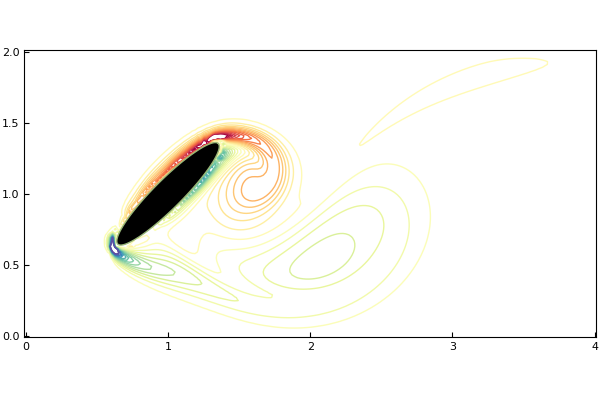

In [29]:
xg,yg = coordinates(w,dx=Δx)
plot(xg,yg,w,levels=linspace(-0.5,0.5,30))
plot!(body,fillcolor=:black)

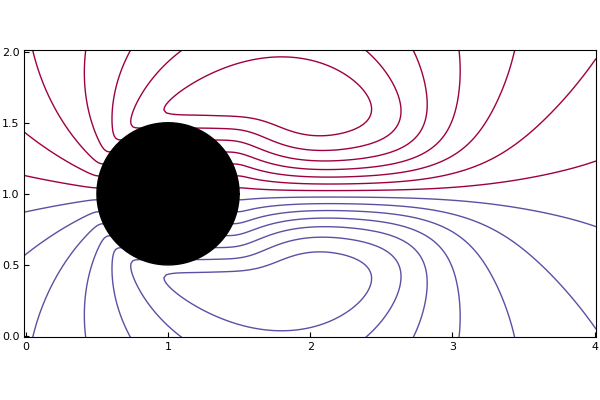

In [29]:
xg,yg = coordinates(w,dx=Δx)
ψ = deepcopy(w)
ψ .= -(sys.L\w)
plot(xg,yg,ψ,clim=(-0.1,0.1))
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=1,linecolor=:black)

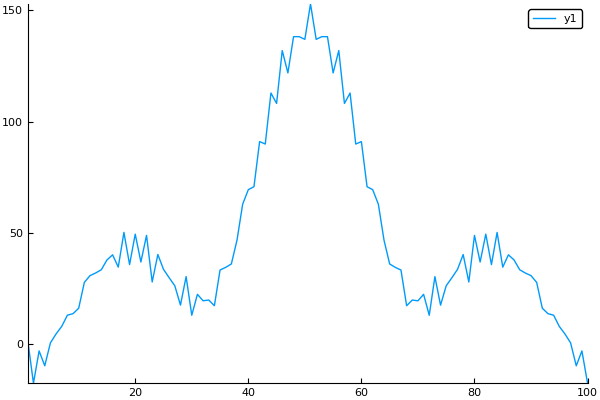

In [20]:
plot(f.u)

In [5]:
regopfilter = Regularize(X,Δx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(regopfilter,f,q);
Ẽmat = InterpolationMatrix(regopfilter,q,f);

In [8]:
P(f::VectorData) = Ẽmat*(H̃mat*f)

P (generic function with 1 method)